# Kaggle Challenge
### 7 June 2019
##### Student 1: Karolina Sidlauskaite (100392576)
##### Student 2: Niall O'Neill (100394545)

First, we load all the libraries that will be used in this project:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from impyute.imputation.cs import fast_knn

Then, we load in the train data and pre-process it accordingly, separating it to input and output data. Since output data is multi-dimensional, we create an array of outputs.

Note: as a starter method, we fill in the missing data by simply using mean values. In the future, the missing value imputation method may be reconsidered.

In [36]:
train_data = pd.read_csv('trainData.csv', header=0)
train_data.fillna(train_data.mean(), inplace=True) #input mean values for all missing cells

train_X = train_data.iloc[:,1:804] # Get all features (ignore first column, as it's an ID)
train_Y = train_data.iloc[:,804:] # Get all classes

print("Input values are of shape: %s" % str(train_X.shape))
print("Output values are of shape: %s" % str(train_Y.shape))

train_Y_sep = [] # now we will separate all Ys so that we can iterate through them

for i in range(train_Y.shape[1]):
    train_Y_sep.append(train_Y.iloc[:,i])

Input values are of shape: (1000, 803)
Output values are of shape: (1000, 14)


Before training the model, it is important to consider what attributes are relevant for our model. To begin with, we are considering a standard SelectKBest feature selection method (with simple linear regression score function)  to roughly see what attributes are more important for building the model. 

All attributes will be sorted from most relevant to least relevant, separately for each output class.

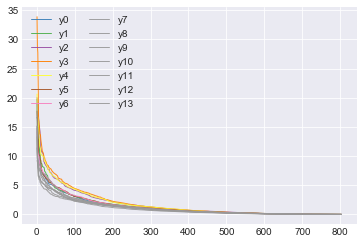

In [4]:
df = pd.DataFrame({'x': range(1,804)})
all_sorted = []

%matplotlib inline  
# We want to rank all attributes, and the best ones will be selected later
selector = SelectKBest(f_regression, k="all")
i = 0
for y_train in train_Y_sep:    
    selector.fit(train_X, y_train)
    sorted_attributes = np.argsort(-selector.scores_)
    all_sorted.append(sorted_attributes)
    sorted_scores = np.sort(-selector.scores_)
    df['y'+str(i)] = -sorted_scores
    i += 1

plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num += 1
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)    
    plt.legend(loc=2, ncol=2)

From above, we can see that roughly, for all attributes, the first 180-200 attributes are more relevant to the model. However, note that for each output, those attributes may defer, hence why we stored all to the array, to pick specifically the ones that are better for a particular output class.

Now, let's consider various classifiers in order to predict the output values for each. Different models have been trained and tested on a third of the training data for each output class, then the average accuracy for each model has been calculated in order to see which model appears to be performing the best.

In [5]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Decision Tree Regressor', DecisionTreeRegressor()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Bernoulli Naive Bayes', BernoulliNB()))
models.append(('Support Vector Machine', svm.SVC(gamma='scale')))
models.append(('XGBoost', XGBClassifier(booster="gblinear", max_depth=5)))
models.append(('Ada Boost', AdaBoostClassifier(n_estimators=20, learning_rate=1)))
models.append(('Cat Boost', CatBoostClassifier(iterations=20, learning_rate=0.05, depth=2, verbose=0)))
models.append(('MLP', MLPClassifier(alpha=1, max_iter=500)))
models.append(('Quadratic Discriminant Analysis', QuadraticDiscriminantAnalysis()))

# evaluate each model in turn

results = []
names = []
for name, model in models:
    score = []
    for i in range(0, len(train_Y_sep)):
        y_train = train_Y_sep[i]
        first_180 = all_sorted[i][:180]
        train_X_red = train_X.iloc[:, first_180]
        X_train, X_test, y_train, y_test = train_test_split(train_X_red, y_train, test_size=0.33, random_state=0)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        score.append(metrics.accuracy_score(y_test, y_test_pred))
    avg_score = sum(score)/len(score)
    print("%s: %f" % (name, avg_score))

Logistic Regression: 0.752814
Linear Discriminant Analysis: 0.743074
KNN: 0.746753
Decision Tree Classifier: 0.679004
Decision Tree Regressor: 0.680303
Gaussian Naive Bayes: 0.769264
Bernoulli Naive Bayes: 0.761039
Support Vector Machine: 0.775758
XGBoost: 0.779221
Ada Boost: 0.730087
Cat Boost: 0.766234
MLP: 0.760823
Quadratic Discriminant Analysis: 0.765368


From above we can see that the top 3 models for predicting the value of all output classes are:

1) XGBoost Classifier

2) Support Vector Machine

3) Gaussian Naive Bayes

Now, we will train the models with all the training data again, and predict the values of the test data and submit the results to Kaggle. This will define the base model results, which we will then try improving.

Start by loading in the test data (use the same mean value imputation for the missing values, if any):

In [37]:
test_data = pd.read_csv('testData_unlabeled.csv', header=0)
test_data.fillna(test_data.mean(), inplace=True) #input mean values for all missing cells

test_X = test_data.iloc[:,1:] # ignore first column

We begin with Gaussian Naive Bayes:

In [7]:
df_gnb = pd.DataFrame(data = {'ID': list(range(0, len(test_X)))})
df_gnb.set_index('ID', inplace=True)
df_gnb.index = df_gnb.index.astype(int)

model = GaussianNB()

for i in range(0, len(train_Y_sep)):
    y_train = train_Y_sep[i]
    first_180 = all_sorted[i][:180]
    train_X_red = train_X.iloc[:, first_180]   
    
    model.fit(train_X_red, y_train)
    test_X_red = test_X.iloc[:, first_180]
    y_val_pred = model.predict(test_X_red)
    df_gnb['Class_'+str(i)] = y_val_pred
    
df_gnb.to_csv("df_gnb.csv", sep=',')
df_gnb.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13
ID,,,,,,,,,,,,,,
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Importing the predictions to Kaggle, this has returned the accuracy score of 0.71.

We do the same now for the SVM:

In [8]:
df_svm = pd.DataFrame(data = {'ID': list(range(0, len(test_X)))})
df_svm.set_index('ID', inplace=True)
df_svm.index = df_svm.index.astype(int)

model = svm.SVC(gamma='scale')

for i in range(0, len(train_Y_sep)):
    y_train = train_Y_sep[i] # Get ith class
    first_180 = all_sorted[i][:180] # Get first 180 relevant attributes' IDs for ith class
    train_X_red = train_X.iloc[:, first_180] # Get respective features for the 180 IDs
    
    model.fit(train_X_red, y_train) # Fit the model
    test_X_red = test_X.iloc[:, first_180] # For the test data, also get respective features for the same 180 IDs
    y_val_pred = model.predict(test_X_red) # Predict output class values
    df_svm['Class_'+str(i)] = y_val_pred

df_svm.to_csv("df_svm.csv", sep=',')
df_svm.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13
ID,,,,,,,,,,,,,,
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Uploading the predictions to Kaggle, this resulted into accuracy score 0.77, which is better than the Gaussian Naive Bayes we ran previously.

Finally, we do the same for the XGBoost classifier:

In [9]:
df_xgb = pd.DataFrame(data = {'ID': list(range(0, len(test_X)))})
df_xgb.set_index('ID', inplace=True)
df_xgb.index = df_xgb.index.astype(int)

model = XGBClassifier(booster="gblinear", max_depth=5)

for i in range(0, len(train_Y_sep)):
    y_train = train_Y_sep[i] # Get ith class
    first_180 = all_sorted[i][:180] # Get first 180 relevant attributes' IDs for ith class
    train_X_red = train_X.iloc[:, first_180] # Get respective features for the 180 IDs
    
    model.fit(train_X_red, y_train) # Fit the model
    test_X_red = test_X.iloc[:, first_180] # For the test data, also get respective features for the same 180 IDs
    y_val_pred = model.predict(test_X_red) # Predict output class values
    df_xgb['Class_'+str(i)] = y_val_pred

df_xgb.to_csv("df_xgb.csv", sep=',')
df_xgb.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13
ID,,,,,,,,,,,,,,
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


This has also returned the accuracy score of 0.77 when uploaded to Kaggle.

So, our base models returned the accuracy between 0.71 and 0.77. Now, we will try to improve on the feature selection, missing value imputation and on best model parameter selections to improve our models.

Let's begin with the Gaussian Naive Bayes model. Let's see if we can improve the accuracy on the training data changing the method for selecting the most relevant attributes for the model. We now try to see whether using ExtraTreesClassifier for the features whose importance is higher than 000.1 could improve our model.

In [40]:
model = GaussianNB()
feats = ExtraTreesClassifier()

score = []

for i in range(0, len(train_Y_sep)):
    y_train = train_Y_sep[i]
    feats.fit(train_X, y_train)
    feat_importances = pd.Series(feats.feature_importances_, index=train_X.columns)
    feat_importances = feat_importances[feat_importances > 0.001]
    ids = list(feat_importances.index)
    
    train_X_red = train_X.loc[:, ids]
    X_train, X_test, y_train, y_test = train_test_split(train_X_red, y_train, test_size=0.33, random_state=0)    

    model.fit(X_train, y_train)
    test_X_red = X_test.loc[:, ids]
    y_val_pred = model.predict(test_X_red)
    score.append(metrics.accuracy_score(y_test, y_test_pred))

avg_score = sum(score)/len(score) 
print("Average accuracy: %f" % avg_score) 

Average accuracy: 0.695022


This doesn't seem to have improved the accuracy, after uploading to Kaggle, we got accuracy 0.72 which was a decrease in what we had previously.

Doing the same for the SVM:

In [41]:
model = svm.SVC(gamma='scale')
feats = ExtraTreesClassifier()

score = []

for i in range(0, len(train_Y_sep)):
    y_train = train_Y_sep[i]
    feats.fit(train_X, y_train)
    feat_importances = pd.Series(feats.feature_importances_, index=train_X.columns)
    feat_importances = feat_importances[feat_importances > 0.001]
    ids = list(feat_importances.index)
    
    train_X_red = train_X.loc[:, ids]
    X_train, X_test, y_train, y_test = train_test_split(train_X_red, y_train, test_size=0.33, random_state=0)    

    model.fit(X_train, y_train)
    test_X_red = X_test.loc[:, ids]
    y_val_pred = model.predict(test_X_red)
    score.append(metrics.accuracy_score(y_test, y_test_pred))

avg_score = sum(score)/len(score) 
print("Average accuracy: %f" % avg_score) 

Average accuracy: 0.695022


Which appeared as a decrease in accuracy, however, after submitting to Kaggle, we got a slight increase to the base model - 0.772.

In [13]:
df_svm = pd.DataFrame(data = {'ID': list(range(0, len(test_X)))})
df_svm.set_index('ID', inplace=True)
df_svm.index = df_svm.index.astype(int)

model = svm.SVC(gamma='scale')

feats = ExtraTreesClassifier()
for i in range(0, len(train_Y_sep)): 
    y_train = train_Y_sep[i]
    feats.fit(train_X, y_train)
    feat_importances = pd.Series(feats.feature_importances_, index=train_X.columns)
    feat_importances = feat_importances[feat_importances > 0.001]
    ids = list(feat_importances.index)
    
    y_train = train_Y_sep[i]
    train_X_red = train_X.loc[:, ids]
    
    model.fit(train_X_red, y_train)
    test_X_red = test_X.loc[:, ids]
    y_val_pred = model.predict(test_X_red)
    df_svm['Class_'+str(i)] = y_val_pred

df_svm.to_csv("df_svm_n.csv", sep=',')
df_svm.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13
ID,,,,,,,,,,,,,,
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Finally, we try the same with the XGBoost classifier:

In [42]:
model = XGBClassifier(booster="gblinear", max_depth=5)
feats = ExtraTreesClassifier()

score = []

for i in range(0, len(train_Y_sep)):
    y_train = train_Y_sep[i]
    feats.fit(train_X, y_train)
    feat_importances = pd.Series(feats.feature_importances_, index=train_X.columns)
    feat_importances = feat_importances[feat_importances > 0.001]
    ids = list(feat_importances.index)
    
    train_X_red = train_X.loc[:, ids]
    X_train, X_test, y_train, y_test = train_test_split(train_X_red, y_train, test_size=0.33, random_state=0)    

    model.fit(X_train, y_train)
    test_X_red = X_test.loc[:, ids]
    y_val_pred = model.predict(test_X_red)
    score.append(metrics.accuracy_score(y_test, y_test_pred))

avg_score = sum(score)/len(score) 
print("Average accuracy: %f" % avg_score) 

Average accuracy: 0.695022


Submitting this to Kaggle - it returned a decrease from the base model - accuracy of 0.759.

In [15]:
df_xgb_n = pd.DataFrame(data = {'ID': list(range(0, len(test_X)))})
df_xgb_n.set_index('ID', inplace=True)
df_xgb_n.index = df_xgb_n.index.astype(int)

model = XGBClassifier(booster="gblinear", max_depth=5)

feats = ExtraTreesClassifier()
for i in range(0, len(train_Y_sep)): 
    y_train = train_Y_sep[i]
    feats.fit(train_X, y_train)
    feat_importances = pd.Series(feats.feature_importances_, index=train_X.columns)
    feat_importances = feat_importances[feat_importances > 0.001]
    ids = list(feat_importances.index)
    
    y_train = train_Y_sep[i]
    train_X_red = train_X.loc[:, ids]
    
    model.fit(train_X_red, y_train)
    test_X_red = test_X.loc[:, ids]
    y_val_pred = model.predict(test_X_red)
    df_xgb_n['Class_'+str(i)] = y_val_pred

df_xgb_n.to_csv("df_xgb_n.csv", sep=',')
df_xgb_n.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13
ID,,,,,,,,,,,,,,
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Now let's see if we can improve the models using alternative methods for imputing missing values. Forst we try fast KNN available at impyute library. Note this will have to be done for both training and test data separately.

In [16]:
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# TRAIN DATA

train_data_knn = pd.read_csv('trainData.csv', header=0)
imputed_training = pd.DataFrame(data = fast_knn(train_data_knn.values, k=30), columns=list(train_data_knn.columns))
imputed_training.set_index('ID', inplace=True)
imputed_training.index = imputed_training.index.astype(int)

train_X_knn = imputed_training.iloc[:,:803] # Get all features (ignore first column, as it's an ID)
train_Y_knn = imputed_training.iloc[:,803:] # Get all classes

train_Y_sep_knn = []

for i in range(train_Y_knn.shape[1]):
    train_Y_sep_knn.append(train_Y_knn.iloc[:,i])
        
# TEST DATA

test_data_knn = pd.read_csv('testData_unlabeled.csv', header=0)
test_X_knn = pd.DataFrame(data = fast_knn(test_data_knn.values, k=30), columns=list(test_data_knn.columns))
test_X_knn.set_index('ID', inplace=True)
test_X_knn.index = test_X_knn.index.astype(int)

To test the improvements we will take base models for Gaussian Naive Bayes and XGBoost, but for SVM, we will take the one where features are selected with Extra Trees Classifier, as that returned better results.

So, we begin with Gaussian Naive Bayes (which appears to be decreasing the accuracy slightly):

In [17]:
model = GaussianNB()

score = []

for i in range(0, len(train_Y_sep_knn)):
    y_train = train_Y_sep_knn[i]
    first_180 = all_sorted[i][:180]
    train_X_red = train_X_knn.iloc[:, first_180]
    X_train, X_test, y_train, y_test = train_test_split(train_X_red, y_train, test_size=0.33, random_state=0)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    score.append(metrics.accuracy_score(y_test, y_test_pred))
    
avg_score = sum(score)/len(score)
print("Average accuracy: %f" % avg_score)

Average accuracy: 0.768831


Then we do the same for the base XGBoost classifier:

In [18]:
model = XGBClassifier(booster="gblinear", max_depth=5)

score = []

for i in range(0, len(train_Y_sep_knn)):
    y_train = train_Y_sep_knn[i]
    first_180 = all_sorted[i][:180]
    train_X_red = train_X_knn.iloc[:, first_180]
    X_train, X_test, y_train, y_test = train_test_split(train_X_red, y_train, test_size=0.33, random_state=0)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    score.append(metrics.accuracy_score(y_test, y_test_pred))
    
avg_score = sum(score)/len(score)
print("Average accuracy: %f" % avg_score)

Average accuracy: 0.779221


This appears to be improving the base model slightly, hence we predict the test dataset values and submit to Kaggle:

In [19]:
df_xgb_knn = pd.DataFrame(data = {'ID': list(range(0, len(test_X)))})
df_xgb_knn.set_index('ID', inplace=True)
df_xgb_knn.index = df_xgb_knn.index.astype(int)

model = XGBClassifier(booster="gblinear", max_depth=5)

for i in range(0, len(train_Y_sep_knn)):
    y_train = train_Y_sep_knn[i] # Get ith class
    first_180 = all_sorted[i][:180] # Get first 180 relevant attributes' IDs for ith class
    train_X_red = train_X_knn.iloc[:, first_180] # Get respective features for the 180 IDs
    
    model.fit(train_X_red, y_train) # Fit the model
    test_X_red = test_X_knn.iloc[:, first_180] # For the test data, also get respective features for the same 180 IDs
    y_val_pred = model.predict(test_X_red) # Predict output class values
    df_xgb_knn['Class_'+str(i)] = y_val_pred

df_xgb_knn.to_csv("df_xgb_knn.csv", sep=',')
df_xgb_knn.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13
ID,,,,,,,,,,,,,,
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Unfortunally, the above returned lower accuracy score on the test data - 0.76, hence hasn't improved the model.

Finally, we apply the same for the SVM, but in this case, we are not applying this to the base model:

In [20]:
model = svm.SVC(gamma='scale')
feats = ExtraTreesClassifier()

score = []

for i in range(0, len(train_Y_sep_knn)):
    y_train = train_Y_sep_knn[i]
    feats.fit(train_X_knn, y_train)
    feat_importances = pd.Series(feats.feature_importances_, index=train_X_knn.columns)
    feat_importances = feat_importances[feat_importances > 0.001]
    ids = list(feat_importances.index)
    
    train_X_red = train_X_knn.loc[:, ids]
    
    model.fit(train_X_red, y_train)
    test_X_red = test_X_knn.loc[:, ids]
    y_val_pred = model.predict(test_X_red)
    score.append(metrics.accuracy_score(y_test, y_test_pred))

avg_score = sum(score)/len(score) 
print("Average accuracy: %f" % avg_score) 

Average accuracy: 0.978788


The above doesn't seem to have done any improvement to what we got previously, hence we decided not to submit the predictions to Kaggle.

Now, let's see whether we can improve the models by adjusting the parameters. We will be using GridSearch cross validation for hyper parameter tuning.

We begin by hyper-parameter tuning for the XGB model:

In [26]:
model = XGBClassifier()

param_grid = {'max_depth': (2,20),
              'booster': ["gblinear", "gbtree", "dart"]}

np.random.seed(0)

score = []

for i in range(0, len(train_Y_sep)):
    y_train = train_Y_sep[i]
    first_180 = all_sorted[i][:180]
    train_X_red = train_X.iloc[:, first_180]
    X_train, X_test, y_train, y_test = train_test_split(train_X_red, y_train, test_size=0.33, random_state=0)   
    clf = GridSearchCV(model, 
                        param_grid,
                        scoring='accuracy',
                        cv=3,    
                        n_jobs=1, verbose=0,
                        refit=True
                        )
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    score.append(metrics.accuracy_score(y_test, y_test_pred))
    
avg_score = sum(score)/len(score)
print("Average accuracy: %f" % avg_score)

Average accuracy: 0.770779


Unfortunately, hyper-parameter tuning doesn't seem to have improved the XGBoost classifier, hence we decided not to submit predictions to Kaggle.

We do the same hyper-parameter tuning for our, so far the best, SVM model with top features selected separately using Extra Trees Classifier for each class.

In [43]:
model = svm.SVC()

G_vals = [1, 2, 'auto', 'scale']
degrees = [2, 3, 4, 5]

param_grid = { 'kernel' : ('linear', 'rbf', 'poly'), 'gamma' : G_vals, 'degree': degrees}
np.random.seed(0)

score = []

feats = ExtraTreesClassifier()
for i in range(0, len(train_Y_sep)): 
    y_train = train_Y_sep[i]
    feats.fit(train_X, y_train)
    feat_importances = pd.Series(feats.feature_importances_, index=train_X.columns)
    feat_importances = feat_importances[feat_importances > 0.001]
    ids = list(feat_importances.index)
    train_X_red = train_X.loc[:, ids]
    X_train, X_test, y_train, y_test = train_test_split(train_X_red, y_train, test_size=0.33, random_state=0)    
    clf = GridSearchCV(model, 
                        param_grid,
                        scoring='accuracy',
                        cv=3,    
                        n_jobs=1, verbose=0,
                        refit=True
                        )
    clf.fit(X_train, y_train)
    test_X_red = X_test.loc[:, ids]
    y_test_pred = clf.predict(test_X_red)
    score.append(metrics.accuracy_score(y_test, y_test_pred))
    
avg_score = sum(score)/len(score)
print("Average accuracy: %f" % avg_score)

Average accuracy: 0.766450


In [44]:
df_svm_cv = pd.DataFrame(data = {'ID': list(range(0, len(test_X)))})
df_svm_cv.set_index('ID', inplace=True)
df_svm_cv.index = df_svm_cv.index.astype(int)

model = svm.SVC()

G_vals = [1, 2, 'auto', 'scale']
degrees = [2, 3, 4, 5]

param_grid = { 'kernel' : ('linear', 'rbf', 'poly'), 'gamma' : G_vals, 'degree': degrees}
np.random.seed(0)

score = []

feats = ExtraTreesClassifier()
for i in range(0, len(train_Y_sep)): 
    y_train = train_Y_sep[i]
    feats.fit(train_X, y_train)
    feat_importances = pd.Series(feats.feature_importances_, index=train_X.columns)
    feat_importances = feat_importances[feat_importances > 0.001]
    ids = list(feat_importances.index)
    train_X_red = train_X.loc[:, ids]
    X_train, X_test, y_train, y_test = train_test_split(train_X_red, y_train, test_size=0.33, random_state=0)    
    clf = GridSearchCV(model, 
                        param_grid,
                        scoring='accuracy',
                        cv=3,    
                        n_jobs=1, verbose=0,
                        refit=True
                        )
    clf.fit(X_train, y_train)
    test_X_red = test_X.loc[:, ids] # For the test data, also get respective features for the same 180 IDs
    y_val_pred = clf.predict(test_X_red) # Predict output class values
    df_svm_cv['Class_'+str(i)] = y_val_pred

df_svm_cv.to_csv("df_xgb_cv.csv", sep=',')
df_svm_cv.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13
ID,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Unfortunately, once again this doesn't seem to have improved the predictions on the test data - accuracy in Kaggle returned 0.771.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_keras = pd.DataFrame(data = {'ID': list(range(0, len(test_X)))})
df_keras.set_index('ID', inplace=True)
df_keras.index = df_keras.index.astype(int)

for i in range(0, len(train_Y_sep)):
    y_train = train_Y_sep[i]
    first_180 = all_sorted[i][:180]
    train_X_red = train_X.iloc[:, first_180]

    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=180))
    model.add(Dense(10, input_dim=180, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    trained = model.fit(train_X_red, y_train, epochs=500, 
                    verbose=0, batch_size=100)

    test_X_red = test_X.iloc[:, first_180]
    y_val_pred = model.predict_classes(test_X_red)
    df_keras['Class_'+str(i)] = y_val_pred 

df_keras = df_keras + 0.0
df_keras.to_csv("df_keras.csv", sep=',')
df_keras.head()